In [1]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm
import sys
sys.path.append('..')
from template import utils

In [2]:
utils.set_random_seeds(False)
torch.use_deterministic_algorithms(False)

In [3]:
# Define the subjects for each split
# In the past, there existed validation and test subjects, but the method changed a bit
train_subjects = [11, 12, 13, 14, 15, 16, 21, 23, 3 ,5 ] #3, 6, 7, 1, 2, 4, 8]

# Define the background variations
background_variations = ['d1','d2', 'd3', 'd4']

processed_folder = '/home/nfs/inf6/data/datasets/kth_actions/processed/'

In [4]:
#load config file and hyperparams
config = yaml.safe_load(open("config.yaml"))
LR = float(config["LR"])
batch_size = int(config["BATCH_SIZE"])
num_epochs = int(config["NUM_EPOCHS"])
num_epochs_resnet = int(config["NUM_EPOCHS_resnet"])

In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # Add more augmentations if needed
])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
class SequencesExtractor:
    def __init__(self, path, num_frames_per_subsequence=20, l2_loss_threshold=100000):
        # Define the number of frames per subsequence
        self.num_frames_per_subsequence = num_frames_per_subsequence
        # List all action folders in the processed folder
        self.classes = os.listdir(path) # folders correspond to classes/labels
        #self.classes = ["boxing", "handclapping", "handwaving"]
        self.class_to_label = {class_name: idx for idx, class_name in enumerate(self.classes)}
        self.id_to_class = {idx: class_name for class_name, idx in self.class_to_label.items()}
        self.l2_loss_threshold = l2_loss_threshold
    
    def get_classes(self):
        return self.classes
    
    def get_encoding_dicts(self):
        return self.class_to_label, self.id_to_class
    
    def _filter_dot_files(self, image_files):
        # Filter out files that start with a dot
        filtered_files = [file for file in image_files if not (file.startswith('.') or not file.startswith('image'))]

        return filtered_files
    
    def _l2cost(self, img1, img2):
        return np.sum((img1 - img2) ** 2)
    
    def _calculate_total_l2loss(self, imgs):
        
        sum_l2s = 0
        for i in range(1, len(imgs)):
            sum_l2s+=np.sum((imgs[i] - imgs[i-1]) ** 2)
        return sum_l2s
    
    def create_sequences(self, subjects, background_variations):
        sequences = []
        target_arr = []
        # Iterate over each action folder
        for action_folder in self.classes:
            target = action_folder
            action_path = os.path.join(processed_folder, action_folder)

            # List all person folders in the action folder
            person_folders_actual = os.listdir(action_path)
            # Filter videos based on subjects and background variations
            person_folders_target = [f'person{subject:02d}_{action_folder}_{bg}' 
                           for subject in subjects 
                           for bg in background_variations]
            person_folders = set(person_folders_actual) & set(person_folders_target) # it can be that some background variations (or smth else) is missing. 
            # Iterate over each person folder
            for person_folder in person_folders:
                person_path = os.path.join(action_path, person_folder)
                # List all image files in the person folder
                image_files = sorted(os.listdir(person_path))
                #filter out files with a dot or something else than img at the start
                image_files = self._filter_dot_files(image_files)
                # Split the image files into subsequences
                num_frames = len(image_files)
                num_subsequences = num_frames // self.num_frames_per_subsequence
                
                for i in range(num_subsequences):
                    start_index = i * self.num_frames_per_subsequence
                    end_index = start_index + self.num_frames_per_subsequence
                    
                    imgs = []
                    # Load and process the frames in the subsequence
                    subsequence_frames = []
                    for j in range(start_index, end_index):
                        # try:
                        image_path = os.path.join(person_path, image_files[j])
                        frame = Image.open(image_path).convert('RGB')
                        imgs.append(np.array(ImageOps.grayscale(frame)))
                        # Apply any desired spatial augmentations to the frame
                        frame = transform(frame)
                        subsequence_frames.append(frame)
        
                    # Perform further processing on the subsequence
                    # Check if subsequence has the expected number of frames
                    if len(subsequence_frames) == self.num_frames_per_subsequence:
                        # Process the subsequence (e.g., feed it to a model for action classification)
                        
                        # that's actually pretty complex way of preprocessing. I wanted to eliminate 
                        # sequences that had empty frames so I wanted to check overall difference in frames throughout the sequence (l2 cost between i+1 and ith images).
                        # Sequences in walking, jogging and running classes suffer from "emptiness". 
                        # Turns out that it wasn't the cause of the bug, so I did not include it.
                        
                        # Perform further processing on the subsequence
                            # if action_folder in ['running', 'jogging', 'walking']:  
                            #     l2loss_acc = self._calculate_total_l2loss(imgs)
                            #     if l2loss_acc > self.l2_loss_threshold:
                            
                        
                        subsequence_frames = torch.stack(subsequence_frames, dim=0)
                        target_arr.append(self.class_to_label[target])
                        sequences.append(subsequence_frames)
                                # else:
                                #     print("Discarding sequence due to lack of overall change in the sequence's imgs")
                                #     print(f"Class : {action_folder}")
                        # else: 
                        #     subsequence_frames = torch.stack(subsequence_frames, dim=0)
                        #     target_arr.append(self.class_to_label[target])
                        #     sequences.append(subsequence_frames)
                                
                    else:
                        print(f"Skipping subsequence due to incorrect number of frames: {len(subsequence_frames)}")
                        # target_arr.append(self.class_to_label[target])
                        # sequences.append(subsequence_frames)
        return np.array(sequences, dtype = np.float64), np.array(target_arr)

In [8]:
sequencesExtractor = SequencesExtractor(path=processed_folder, num_frames_per_subsequence=20)
train_sequences, train_target_arr = sequencesExtractor.create_sequences(train_subjects, background_variations)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
len(train_sequences)

5854

In [11]:
train_sequences, val_sequences, train_target_arr, val_target_arr = train_test_split(train_sequences, train_target_arr, test_size=0.33, random_state=1)

In [12]:
def create_dataloaders(inputs, labels, batch_size, shuffle=False):
    input_tensor = torch.tensor(inputs, dtype=torch.float32)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
    return dataloader

In [13]:
print(f"Training sequences length: {len(train_sequences)}")
print(f"Validation sequences length: {len(val_sequences)}")

Training sequences length: 3922
Validation sequences length: 1932


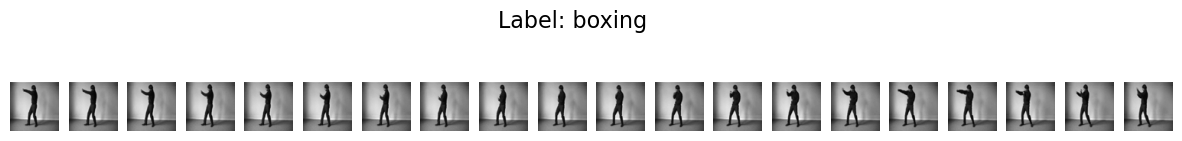

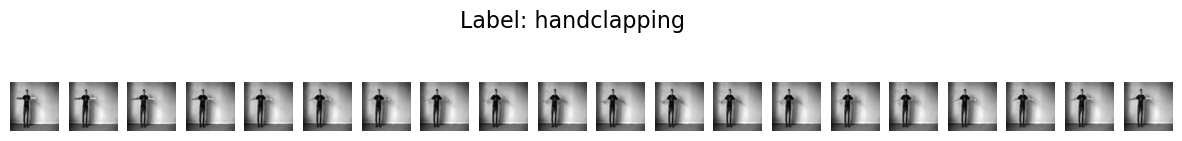

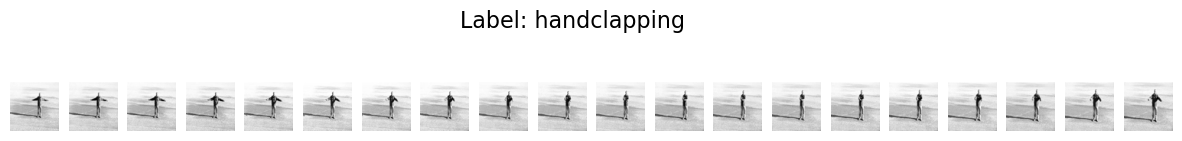

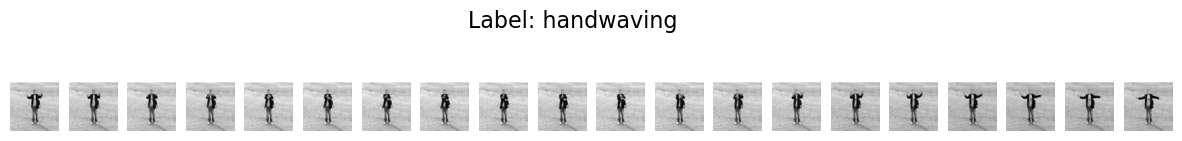

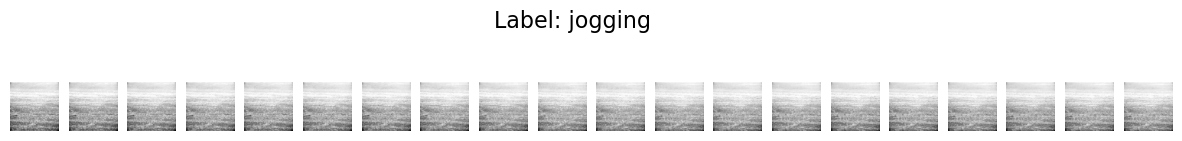

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in the variables data_array and label_array
# Replace these with your actual variable names
_, label_to_class = sequencesExtractor.get_encoding_dicts()
data_array = train_sequences # Replace this with your actual data
label_array = train_target_arr  # Replace this with your actual labels

# Choose a random index to select one sequence
random_indices = np.random.choice(len(data_array), size=5, replace=False)

for random_index in random_indices:
    # Get the random sequence and its label
    selected_sequence = data_array[random_index]
    label = label_array[random_index]

    # Visualize the sequence
    fig, axes = plt.subplots(1, selected_sequence.shape[0], figsize=(15, 2))

    # Display images in the sequence
    for i in range(selected_sequence.shape[0]):
        axes[i].imshow(selected_sequence[i, 0, :, :], cmap='gray')
        axes[i].axis('off')

    # Set the label as the title of the plot
    fig.suptitle(f"Label: {label_to_class[label]}", fontsize=16)

    # Show the plot
    plt.show()


In [15]:
from torch.utils.data import Dataset, DataLoader

In [16]:
#This is also a valid way to create a dataset, I was just looking for a bug and created create_dataloaders function and stuck by it
class KTHDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]

        return sequence, label

In [17]:
# train_dataset = KTHDataset(train_sequences, train_target_arr)
# test_dataset = KTHDataset(test_sequences, test_target_arr)
# val_dataset = KTHDataset(val_sequences, val_target_arr)

In [18]:
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_dataloader = create_dataloaders(train_sequences,train_target_arr, batch_size=batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_sequences,val_target_arr, batch_size=batch_size, shuffle=True)
#test_dataloader = create_dataloaders(test_sequences,test_target_arr, batch_size=batch_size, shuffle=True)

In [19]:
if(not os.path.exists("models")):
    os.makedirs("models")

# Self-implemented LSTM cells

## LSTM - Cell

In [20]:
class OurLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(OurLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Input gate
        self.W_ii = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_ii = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hi = nn.Parameter(torch.Tensor(hidden_size))

        # Forget gate
        self.W_if = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_if = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hf = nn.Parameter(torch.Tensor(hidden_size))

        # Cell gate
        self.W_ig = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_ig = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hg = nn.Parameter(torch.Tensor(hidden_size))

        # Output gate
        self.W_io = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_io = nn.Parameter(torch.Tensor(hidden_size))
        self.b_ho = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            # dimension greater equal to 2 is typically associated with weight tensors
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
            # bias tensors are commonly initialized to 0
                nn.init.zeros_(p.data)
    
    
    def forward(self, x, init_states=None):
        # bs, _ = x.size()

        # Access prior hidden state if existent, else initialize to zero (i.e. future is unknown)
        h_t, c_t = (torch.zeros(self.hidden_size).to(x.device),
                    torch.zeros(self.hidden_size).to(x.device)) if init_states is None else init_states

        # We note: In a perfect world, this should be parallelized
        # Input gate
        i_t = torch.sigmoid(x @ self.W_ii.t() + self.b_ii + h_t @ self.W_hi.t() + self.b_hi)
        
        # Forget gate
        f_t = torch.sigmoid(x @ self.W_if.t() + self.b_if + h_t @ self.W_hf.t() + self.b_hf)
        
        # Cell gate
        g_t = torch.tanh(x @ self.W_ig.t() + self.b_ig + h_t @ self.W_hg.t() + self.b_hg)
        
        # Output gate
        o_t = torch.sigmoid(x @ self.W_io.t() + self.b_io + h_t @ self.W_ho.t() + self.b_ho)
        
        # Note: * is the Hadamard product
        # Update cell state
        c_t = f_t * c_t + i_t * g_t

        # Update hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

## ConvLSTM cell

In [21]:
class ConvLSTMCell(nn.Module):
    def __init__(self, channels, input_size, kernel_size = 3):
        '''
        Params:

        channels: number of channels, which is used as input and output
        input_size: The input size of the image
        kernel_size: size of the convolutional kernel
        '''
        super(ConvLSTMCell, self).__init__()

        self.input_size = input_size
        self.kernel_size = kernel_size

        # Input gate
        self.W_ii = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.W_hi = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.b_i = nn.Parameter(torch.zeros(channels, input_size, input_size))

        # Forget gate
        self.W_if = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.W_hf = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.b_f = nn.Parameter(torch.zeros(channels, input_size, input_size))

        # Cell gate
        self.W_ig = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.W_hg = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.b_g = nn.Parameter(torch.zeros(channels, input_size, input_size))

        # Output gate
        self.W_io = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.W_ho = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.b_o = nn.Parameter(torch.zeros(channels, input_size, input_size))

        self.init_weights()

    # Same as above
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, init_states=None):
        bs, channels, rows, cols = x.size()

        h_t, c_t = (torch.zeros(self.input_size).to(x.device),
                    torch.zeros(self.input_size)) if init_states is None else init_states

        
        # Input gate
        i_t = torch.sigmoid(self.W_ii(x) + self.b_i + self.W_hi(h_t))
        
        # Forget gate
        f_t = torch.sigmoid(self.W_if(x) + self.W_hf(h_t) + self.b_f)
        
        # Cell gate
        g_t = torch.tanh(self.W_ig(x) + self.b_g + self.W_hg(h_t))
        
        # Output gate
        o_t = torch.sigmoid(self.W_io(x) + self.b_o + self.W_ho(h_t))
        
        # Update cell state
        c_t = f_t * c_t + i_t * g_t

        # Update hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

In [22]:
class ConvBlock(nn.Module):
    """
    Encapuslation of a convolutional block (conv + activation + pooling)
    """
    def __init__(self, in_ch, out_ch, k_size, pool=False, dropout_prob = 0.2, mxpool_stride=1):
        super(ConvBlock, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_ch, out_ch, k_size))
        layers.append(nn.ReLU())
        if(pool):
            layers.append(nn.MaxPool2d(kernel_size=2, stride = mxpool_stride))
       # layers.append(nn.Dropout(p=dropout_prob))
        self.module = nn.Sequential(*layers)
    def forward(self, x):
        return(self.module(x))


In [23]:
class ConvRecurrentClassifier(nn.Module):
    def __init__(self, input_channels, hidden_size, num_classes,num_layers = 10, mode="random", recurrent_module="lstm"):
        assert mode in ["zeros", "random"]
        super(ConvRecurrentClassifier, self).__init__()
        self.mode = mode
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        
        self.conv_encoder = nn.Sequential(
            # Add more convolutional layers if needed
            ConvBlock(3, 16, 3, pool=False),
            ConvBlock(16, 32, 3, pool=True, mxpool_stride=2),
            ConvBlock(32, 64, 3, pool=False),
            ConvBlock(64, 128, 3, pool=True, mxpool_stride=2),
            ConvBlock(128, 256, 3, pool=False),
            ConvBlock(256, 512, 3, pool=True, mxpool_stride=2),
            ConvBlock(512, 1024, 3, pool=False)
        )
        
        #Recurrent Module
        if recurrent_module == "lstm":
            # LSTM model  
            lstms = []
            for i in range(num_layers):
                in_size = 4096 if i == 0 else self.hidden_dim
                lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=self.hidden_dim) )
            self.lstm = nn.ModuleList(lstms)
            self.recurrent_module = self._LSTMforward
        elif recurrent_module == "gru":
            grus = []
            for i in range(num_layers):
                in_size = 4096 if i == 0 else self.hidden_dim
                grus.append(nn.GRUCell(input_size=in_size, hidden_size=self.hidden_dim))
            self.gru = nn.ModuleList(grus)
            self.recurrent_module = self._GRUforward
        elif recurrent_module == "our_lstm":
            # LSTM model  
            lstms = []
            for i in range(num_layers):
                in_size = 4096 if i == 0 else self.hidden_dim
                lstms.append(OurLSTMCell(input_size=in_size, hidden_size=self.hidden_dim))
            self.lstm = nn.ModuleList(lstms)
            self.recurrent_module = self._OurLSTMforward
            
        
        
        #Recurrent Module
        # self.lstm = nn.LSTM(input_size=4096, hidden_size=hidden_size, batch_first=True)
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )
    
    def _OurLSTMforward(self, embeddings, b_size):
        h, c = self.lstm_init_state(b_size=b_size, device=device)
        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, init_states = (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
        # Take the output from the last time step
        out = lstm_out[:, -1, :]
        return out
    
    def _LSTMforward(self, embeddings, b_size):
        h, c = self.lstm_init_state(b_size=b_size, device=device)
        lstm_out = []
        for i in range(embeddings.shape[1]):
            lstm_input = embeddings[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
        # Take the output from the last time step
        out = lstm_out[:, -1, :]
        return out
    
    def _GRUforward(self, embeddings, b_size):
        h = self.gru_init_state(b_size=b_size, device=device)
        gru_out = []
        for i in range(embeddings.shape[1]):
            gru_input = embeddings[:, i, :]
            # iterating over GRU Cells
            for j, gru_cell in enumerate(self.gru):
                h[j] = gru_cell(gru_input, h[j])
                gru_input = h[j]
            gru_out.append(gru_input)
        gru_out = torch.stack(gru_out, dim=1)
        # Take the output from the last time step
        out = gru_out[:, -1, :]
        return out
    
    def forward(self, x):
        b_size, seq_length, n_channels, width, height = x.shape
        # Reshape input to (batch_size, channels, sequence_length*height, width)
        x = x.view(b_size*seq_length, n_channels, width, height)
        
       # h, c = self.init_state(b_size=b_size, device=device)
         # Convolutional Encoder
        x = self.conv_encoder(x)
        
        # Reshape for LSTM
        embeddings = x.view(b_size, seq_length, -1)
        # Recurrent Module
        out = self.recurrent_module(embeddings, b_size)
        
        
        # Classifier
        out = self.classifier(out)
        
        return out
    def lstm_init_state(self, b_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
            c = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h, c
    
    def gru_init_state(self, b_size, device):
        """ Initializing hidden state """
        if(self.mode == "zeros"):
            h = [torch.zeros(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        elif(self.mode == "random"):
            h = [torch.randn(b_size, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        return h

## Recurrent Network with ConvLSTM



We updated the Conv Block to support padding, in order to maintain a larger image size. A larger image size was needed to ensure that a usage of the ConvLSTM was sensible.

In [24]:
class ConvBlock_2(nn.Module):
    """
    Encapuslation of a convolutional block (conv + activation + pooling)
    """
    def __init__(self, in_ch, out_ch, k_size, pool=False, dropout_prob = 0.2, mxpool_stride=1, pad=1):
        super(ConvBlock_2, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_ch, out_ch, k_size, padding=pad))
        layers.append(nn.ReLU())
        if(pool):
            layers.append(nn.MaxPool2d(kernel_size=2, stride = mxpool_stride))
       # layers.append(nn.Dropout(p=dropout_prob))
        self.module = nn.Sequential(*layers)
    def forward(self, x):
        return(self.module(x))


In [25]:
class ConvLSTMRecurrentClassifier(nn.Module):
    def __init__(self, input_channels, hidden_size, num_classes,num_layers = 3, mode="random", recurrent_module="lstm"):
        assert mode in ["zeros", "random"]
        super(ConvLSTMRecurrentClassifier, self).__init__()
        self.mode = mode
        self.num_layers = num_layers
        self.hidden_dim = hidden_size

        
        self.conv_encoder = nn.Sequential(

            ConvBlock_2(3, 16, 3, pool=False),
            ConvBlock_2(16, 32, 3, pool=True, mxpool_stride=2),
            ConvBlock_2(32, 64, 3, pool=False),
            ConvBlock_2(64, 128, 3, pool=True, mxpool_stride=2),

        )

        self.lstms = []
        # ConvLSTM cells
        self.lstms.append(ConvLSTMCell(128, 16))
        for _ in range(num_layers - 1):
            self.lstms.append((ConvLSTMCell(128, hidden_size)))
        self.lstm = nn.ModuleList(self.lstms)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*hidden_size*128, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, sequence_length, input_size)
        batch_size = x.shape[0]
        seq_length = x.shape[1]
        channels = x.shape[2]
        height = x.shape[3]
        width = x. shape[4]

        final_channels = 128
        
        # Use Conv Encoder
        x = x.view(batch_size*seq_length, channels, width, height)

        x = self.conv_encoder(x)

        x = x.view(batch_size, seq_length, final_channels, self.hidden_dim, self.hidden_dim)

        # Initial hidden and cell states
        h = [torch.zeros(final_channels, self.hidden_dim, self.hidden_dim).to(device) for _ in range(self.num_layers)]
        c = [torch.zeros(final_channels, self.hidden_dim, self.hidden_dim).to(device) for _ in range(self.num_layers)]

        # Process each time step using ConvLSTM cells

        for i in range(x.shape[1]):
            lstm_input = x[:, i, :, :]
            # iterating over ConvLSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, init_states =  (h[j], c[j]))
                lstm_input = h[j]

        x = h[-1].reshape(batch_size, -1)
        # Fully connected layer for classification (using the output from the last time step)

        out = self.classifier(x)
        
        return out

## Defining training loop
### (for some reason, i've got bugs when putting it in utils)

In [29]:
@torch.no_grad()
def eval_model(chosen_model, eval_loader, criterion, device, model_type = "whatever"):
    """ 
    Evaluating the model for either validation or test.

    Parameters:
    - model (nn.Module): The trained neural network model to be evaluated.
    - eval_loader (torch.utils.data.DataLoader): DataLoader for the validation or test dataset.
    - criterion (nn.Module): The loss function.
    - device (torch.device): The device on which to perform evaluation (e.g., 'cuda' or 'cpu').

    Returns:
    - float: Accuracy on the validation or test dataset.
    - float: Mean loss on the validation or test dataset.
    """    
    correct = 0
    total = 0
    loss_list = []
    
    for sequences, labels in eval_loader:
        inputs = sequences.to(device)
        labels = labels.to(device)
        if model_type == "resnet":
            inputs = torch.movedim(inputs, 1, 2)
        
        # Forward pass only to get logits/output
        outputs = chosen_model(inputs)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss

In [30]:
def train_model_v4(num_epochs, chosen_model, train_dataloader, val_dataloader, optimizer, criterion, device, model_type = "whatever",
                  scheduler = None): 
    loss_hist = []
    train_acc_hist = []
    valid_acc_hist = []
    valid_loss_hist = []
    best_loss = 100
    for epoch in range(num_epochs):
        loss_list = []
        acc_list = []
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, (sequences, labels) in progress_bar:
            sequences = sequences.to(device)
            labels = labels.to(device)
            if model_type == "resnet":
                sequences = torch.movedim(sequences, 1,2)
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = chosen_model(sequences)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            with torch.no_grad():
                predicted = outputs.argmax(dim=-1)
                correct = (predicted == labels).sum().item()
                accuracy = correct/labels.shape[0] * 100
            acc_list.append(accuracy)
            # Getting gradients w.r.t. parameters
            loss.backward()
           # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2.0)
            # Updating parameters
            optimizer.step()
            if scheduler:
                scheduler.step()

            progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. train accuracy: {accuracy}")

        loss_hist.append(np.mean(loss_list))
        train_acc_hist.append(np.mean(acc_list))
        val_accuracy, valid_loss = eval_model(chosen_model, val_dataloader, criterion, device, model_type)
        if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': chosen_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, f"models/{model_type}_epoch_{epoch}.pth")
        print(f"Val accuracy at epoch {epoch}: {round(val_accuracy, 2)}%")
        valid_loss_hist.append(valid_loss)
        valid_acc_hist.append(val_accuracy)
    return train_acc_hist, loss_hist, valid_acc_hist, valid_loss_hist

In [27]:
print(len(sequencesExtractor.get_classes()))

6


In [28]:
model_gru = ConvRecurrentClassifier(input_channels=3, hidden_size=512, num_classes=len(sequencesExtractor.get_classes()),recurrent_module="gru")

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model_gru.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=num_epochs)
model_gru = model_gru.to(device)

In [30]:
model_parameters = filter(lambda p: p.requires_grad, model_gru.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

27559846


In [31]:
torch.cuda.empty_cache()

In [32]:
# from template import utils

In [33]:
#training GRU
train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model_v4(num_epochs,
                                                                              model_gru, 
                                                                              train_dataloader, 
                                                                              val_dataloader,
                                                                              optimizer, 
                                                                              criterion,
                                                                              device,
                                                                              "gru")

Epoch 1 Iter 31: loss 1.80232. train accuracy: 13.414634146341465: 100%|█████████████████████████████| 31/31 [00:16<00:00,  1.86it/s]


Val accuracy at epoch 0: 22.62%


Epoch 2 Iter 31: loss 1.39724. train accuracy: 31.70731707317073: 100%|██████████████████████████████| 31/31 [00:11<00:00,  2.64it/s]


Val accuracy at epoch 1: 35.3%


Epoch 3 Iter 31: loss 1.33092. train accuracy: 34.146341463414636: 100%|█████████████████████████████| 31/31 [00:11<00:00,  2.61it/s]


Val accuracy at epoch 2: 34.58%


Epoch 4 Iter 31: loss 1.31477. train accuracy: 40.243902439024396: 100%|█████████████████████████████| 31/31 [00:11<00:00,  2.61it/s]


Val accuracy at epoch 3: 36.75%


Epoch 5 Iter 31: loss 1.78320. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:11<00:00,  2.60it/s]


Val accuracy at epoch 4: 22.88%


Epoch 6 Iter 31: loss 1.85894. train accuracy: 12.195121951219512: 100%|█████████████████████████████| 31/31 [00:11<00:00,  2.60it/s]


Val accuracy at epoch 5: 16.56%


Epoch 7 Iter 31: loss 1.78372. train accuracy: 17.073170731707318: 100%|█████████████████████████████| 31/31 [00:11<00:00,  2.59it/s]


Val accuracy at epoch 6: 17.49%


Epoch 8 Iter 31: loss 1.81067. train accuracy: 17.073170731707318: 100%|█████████████████████████████| 31/31 [00:11<00:00,  2.59it/s]


Val accuracy at epoch 7: 17.13%


Epoch 9 Iter 31: loss 1.80394. train accuracy: 12.195121951219512: 100%|█████████████████████████████| 31/31 [00:11<00:00,  2.59it/s]


Val accuracy at epoch 8: 16.2%


Epoch 10 Iter 31: loss 1.80655. train accuracy: 14.634146341463413: 100%|████████████████████████████| 31/31 [00:11<00:00,  2.59it/s]


Val accuracy at epoch 9: 17.44%


Epoch 11 Iter 31: loss 1.81387. train accuracy: 13.414634146341465: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.58it/s]


Val accuracy at epoch 10: 16.56%


Epoch 12 Iter 31: loss 1.79254. train accuracy: 14.634146341463413: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


Val accuracy at epoch 11: 16.51%


Epoch 13 Iter 31: loss 1.81378. train accuracy: 12.195121951219512: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


Val accuracy at epoch 12: 17.44%


Epoch 14 Iter 31: loss 1.80204. train accuracy: 17.073170731707318: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


Val accuracy at epoch 13: 17.13%


Epoch 15 Iter 31: loss 1.80268. train accuracy: 20.73170731707317: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.56it/s]


Val accuracy at epoch 14: 17.13%


Epoch 16 Iter 31: loss 1.79952. train accuracy: 20.73170731707317: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.56it/s]


Val accuracy at epoch 15: 18.43%


Epoch 17 Iter 31: loss 1.81881. train accuracy: 19.51219512195122: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


Val accuracy at epoch 16: 18.58%


Epoch 18 Iter 31: loss 1.78443. train accuracy: 25.609756097560975: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.56it/s]


Val accuracy at epoch 17: 19.62%


Epoch 19 Iter 31: loss 1.79748. train accuracy: 21.951219512195124: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.55it/s]


Val accuracy at epoch 18: 19.51%


Epoch 20 Iter 31: loss 1.79418. train accuracy: 24.390243902439025: 100%|████████████████████████████| 31/31 [00:12<00:00,  2.55it/s]


Val accuracy at epoch 19: 18.17%


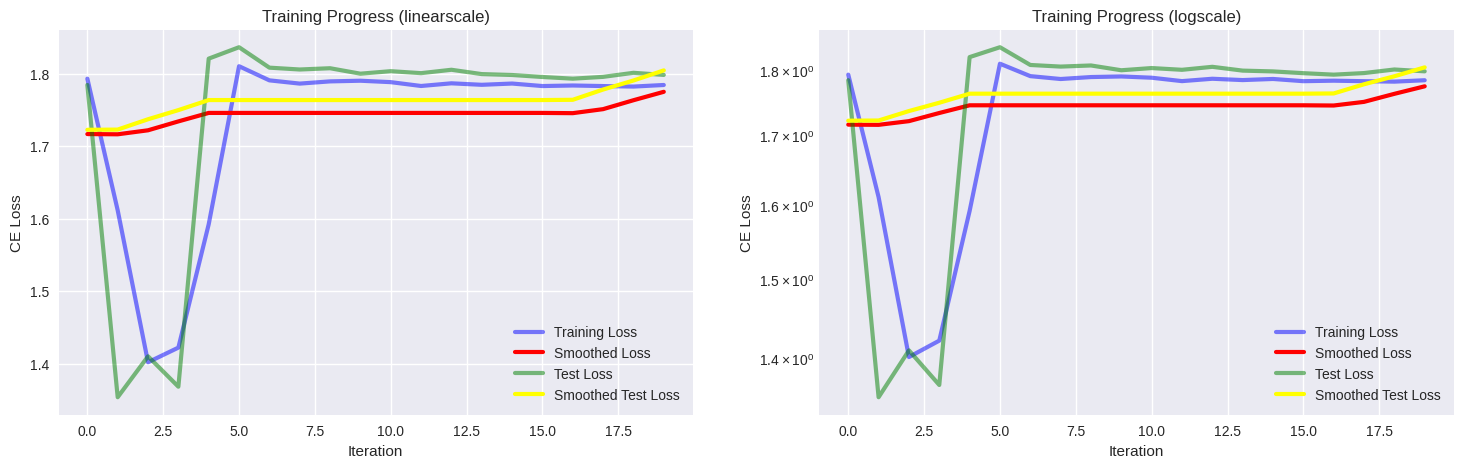

In [36]:
utils.plot_loss(train_loss_hist, val_loss_hist)

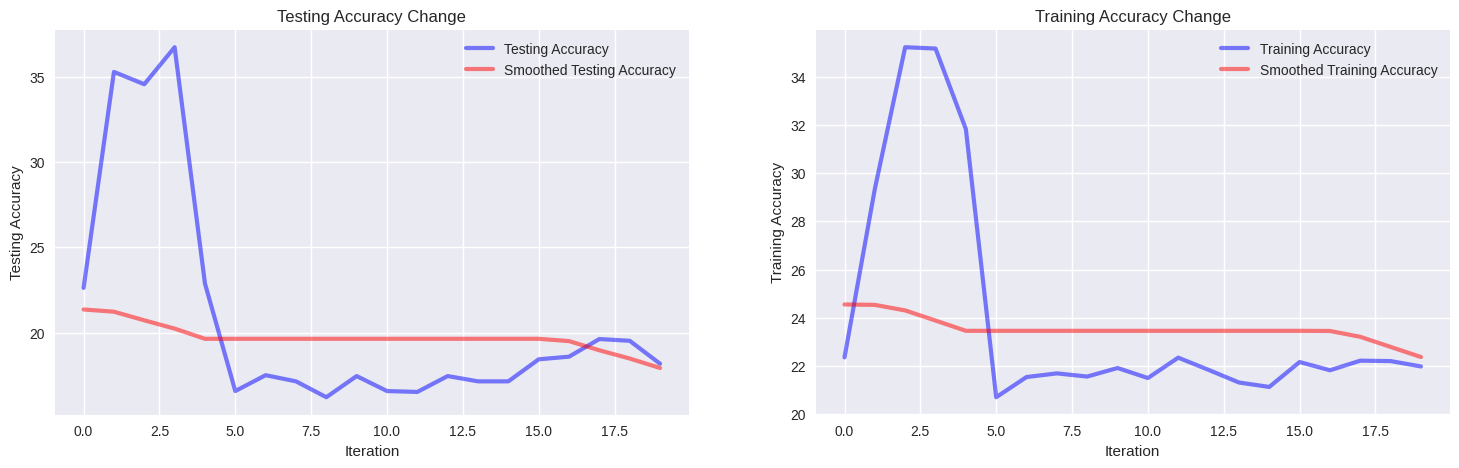

In [37]:
utils.plot_accuracy(train_acc_hist, val_acc_hist)

In [38]:
# training LSTMs
model_lstm = ConvRecurrentClassifier(input_channels=3, hidden_size=512, num_classes=len(sequencesExtractor.get_classes()),recurrent_module="lstm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model_lstm.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=num_epochs)
model_lstm = model_lstm.to(device)

In [39]:
#training GRU
train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model_v4(num_epochs,
                                                                              model_lstm, 
                                                                              train_dataloader, 
                                                                              val_dataloader,
                                                                              optimizer, 
                                                                              criterion,
                                                                              device,
                                                                              "lstm")

Epoch 1 Iter 31: loss 1.76753. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.58it/s]


Val accuracy at epoch 0: 22.62%


Epoch 2 Iter 31: loss 1.75853. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:11<00:00,  2.59it/s]


Val accuracy at epoch 1: 22.62%


Epoch 3 Iter 31: loss 1.75793. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.58it/s]


Val accuracy at epoch 2: 22.62%


Epoch 4 Iter 31: loss 1.75813. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.57it/s]


Val accuracy at epoch 3: 22.62%


Epoch 5 Iter 31: loss 1.75852. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.56it/s]


Val accuracy at epoch 4: 22.62%


Epoch 6 Iter 31: loss 1.75886. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.55it/s]


Val accuracy at epoch 5: 22.62%


Epoch 7 Iter 31: loss 1.75905. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.56it/s]


Val accuracy at epoch 6: 22.62%


Epoch 8 Iter 31: loss 1.75915. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.56it/s]


Val accuracy at epoch 7: 22.62%


Epoch 9 Iter 31: loss 1.75916. train accuracy: 28.04878048780488: 100%|██████████████████████████████| 31/31 [00:12<00:00,  2.55it/s]


Val accuracy at epoch 8: 22.62%


Epoch 10 Iter 31: loss 1.75913. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.54it/s]


Val accuracy at epoch 9: 22.62%


Epoch 11 Iter 31: loss 1.75906. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.51it/s]


Val accuracy at epoch 10: 22.62%


Epoch 12 Iter 31: loss 1.75901. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.54it/s]


Val accuracy at epoch 11: 22.62%


Epoch 13 Iter 31: loss 1.75897. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.53it/s]


Val accuracy at epoch 12: 22.62%


Epoch 14 Iter 31: loss 1.75892. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.53it/s]


Val accuracy at epoch 13: 22.62%


Epoch 15 Iter 31: loss 1.75886. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.52it/s]


Val accuracy at epoch 14: 22.62%


Epoch 16 Iter 31: loss 1.75880. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.53it/s]


Val accuracy at epoch 15: 22.62%


Epoch 17 Iter 31: loss 1.75876. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.52it/s]


Val accuracy at epoch 16: 22.62%


Epoch 18 Iter 31: loss 1.75871. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.51it/s]


Val accuracy at epoch 17: 22.62%


Epoch 19 Iter 31: loss 1.75867. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.52it/s]


Val accuracy at epoch 18: 22.62%


Epoch 20 Iter 31: loss 1.75864. train accuracy: 28.04878048780488: 100%|█████████████████████████████| 31/31 [00:12<00:00,  2.52it/s]


Val accuracy at epoch 19: 22.62%


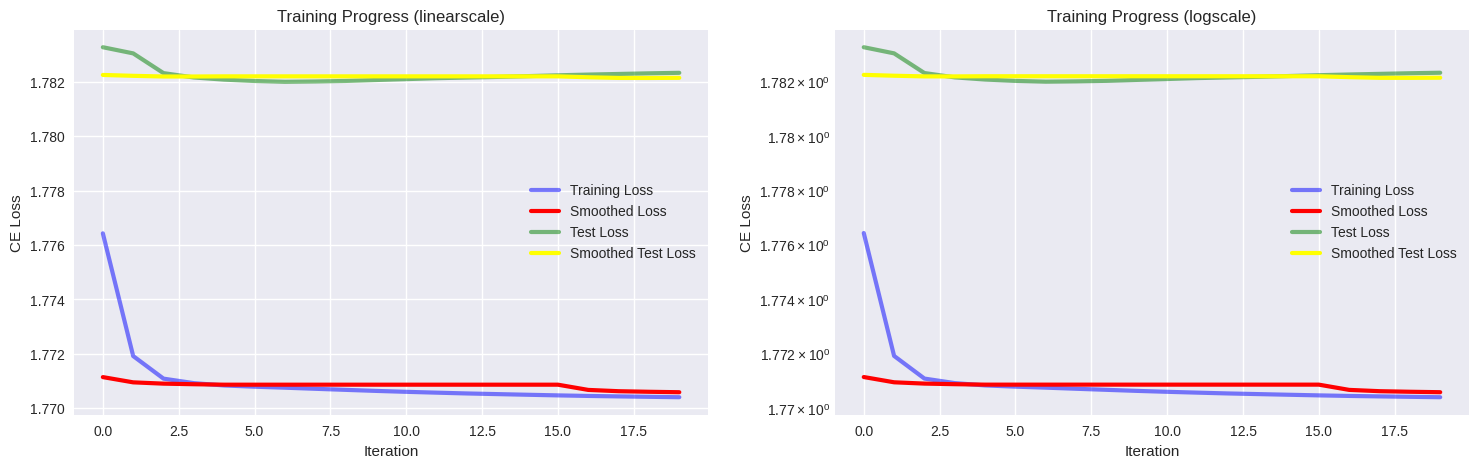

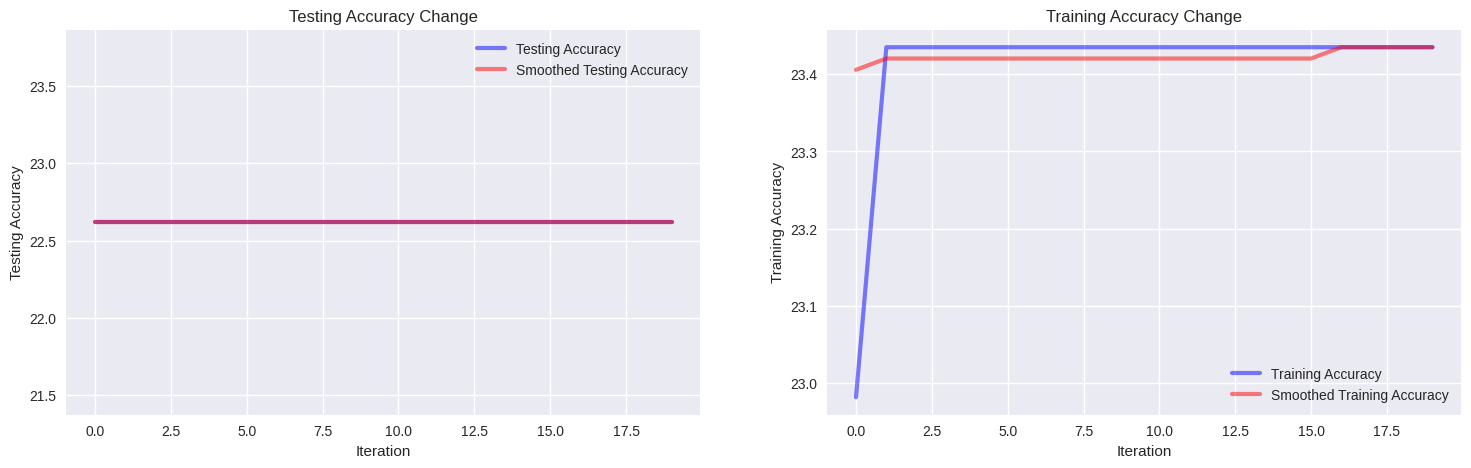

In [40]:
utils.plot_loss(train_loss_hist, val_loss_hist)
utils.plot_accuracy(train_acc_hist, val_acc_hist)

In [46]:
#training our own lstm
model_our_lstm = ConvRecurrentClassifier(input_channels=3, hidden_size=512, num_classes=len(sequencesExtractor.get_classes()),recurrent_module="our_lstm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.AdamW(model_our_lstm.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=num_epochs)
model_our_lstm = model_our_lstm.to(device)

In [ ]:
train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model_v4(num_epochs,
                                                                              model_our_lstm, 
                                                                              train_dataloader, 
                                                                              val_dataloader,
                                                                              optimizer, 
                                                                              criterion,
                                                                              device,
                                                                              "our_lstm")

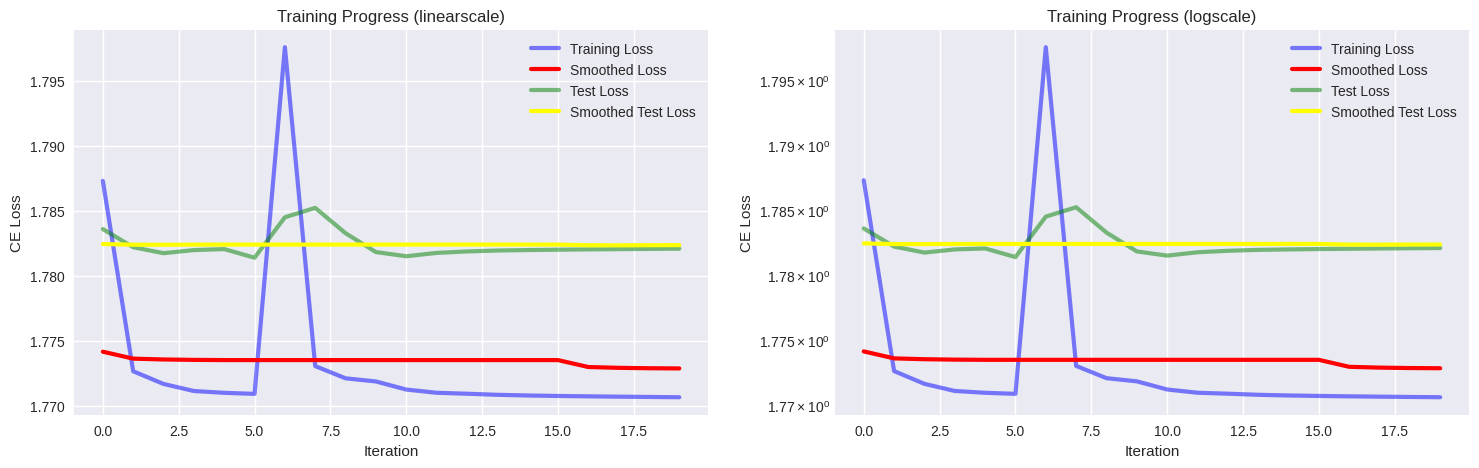

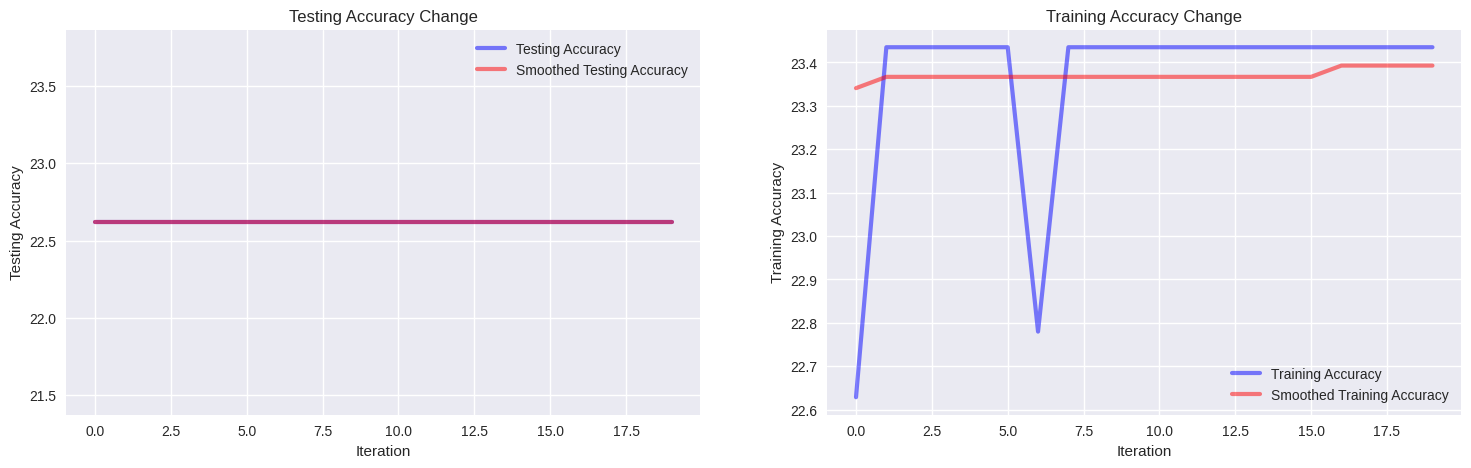

In [43]:
utils.plot_loss(train_loss_hist, val_loss_hist)
utils.plot_accuracy(train_acc_hist, val_acc_hist)

In [31]:
#training ConvLSTM 
model = ConvLSTMRecurrentClassifier(input_channels=3, hidden_size=16,num_layers=3, num_classes=len(sequencesExtractor.get_classes()),recurrent_module="lstm")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=num_epochs)
model = model.to(device)

In [32]:
train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model_v4(num_epochs,
                                                                              model, 
                                                                              train_dataloader, 
                                                                              val_dataloader,
                                                                              optimizer, 
                                                                              criterion,
                                                                              device,
                                                                              "ConvLSTM")

Epoch 1 Iter 62: loss 1.28501. train accuracy: 27.77777777777778: 100%|██████████| 62/62 [00:37<00:00,  1.66it/s]


Val accuracy at epoch 0: 39.23%


Epoch 2 Iter 62: loss 0.83656. train accuracy: 61.111111111111114: 100%|██████████| 62/62 [00:33<00:00,  1.87it/s]


Val accuracy at epoch 1: 48.03%


Epoch 3 Iter 62: loss 0.97999. train accuracy: 55.55555555555556: 100%|██████████| 62/62 [00:33<00:00,  1.86it/s]


Val accuracy at epoch 2: 52.59%


Epoch 4 Iter 62: loss 0.56490. train accuracy: 77.77777777777779: 100%|██████████| 62/62 [00:33<00:00,  1.85it/s]


Val accuracy at epoch 3: 63.04%


Epoch 5 Iter 62: loss 0.54505. train accuracy: 66.66666666666666: 100%|██████████| 62/62 [00:33<00:00,  1.83it/s]


Val accuracy at epoch 4: 66.82%


Epoch 6 Iter 62: loss 0.50407. train accuracy: 77.77777777777779: 100%|██████████| 62/62 [00:33<00:00,  1.82it/s]


Val accuracy at epoch 5: 70.19%


Epoch 7 Iter 62: loss 0.34142. train accuracy: 83.33333333333334: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Val accuracy at epoch 6: 72.26%


Epoch 8 Iter 62: loss 0.25738. train accuracy: 88.88888888888889: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Val accuracy at epoch 7: 72.93%


Epoch 9 Iter 62: loss 0.27687. train accuracy: 77.77777777777779: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Val accuracy at epoch 8: 73.19%


Epoch 10 Iter 62: loss 0.24981. train accuracy: 88.88888888888889: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Val accuracy at epoch 9: 74.07%


Epoch 11 Iter 62: loss 0.19173. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]  


Val accuracy at epoch 10: 77.95%


Epoch 12 Iter 62: loss 0.18004. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]  


Val accuracy at epoch 11: 79.45%


Epoch 13 Iter 62: loss 0.19353. train accuracy: 88.88888888888889: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


Val accuracy at epoch 12: 78.99%


Epoch 14 Iter 62: loss 0.19310. train accuracy: 88.88888888888889: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]


Val accuracy at epoch 13: 77.8%


Epoch 15 Iter 62: loss 0.13843. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]  


Val accuracy at epoch 14: 80.49%


Epoch 16 Iter 62: loss 0.13082. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]  


Val accuracy at epoch 15: 79.55%


Epoch 17 Iter 62: loss 0.03512. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.81it/s]  


Val accuracy at epoch 16: 84.63%


Epoch 18 Iter 62: loss 0.03355. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]  


Val accuracy at epoch 17: 85.82%


Epoch 19 Iter 62: loss 0.00887. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]  


Val accuracy at epoch 18: 87.11%


Epoch 20 Iter 62: loss 0.00594. train accuracy: 100.0: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]  


Val accuracy at epoch 19: 88.15%


utils.plot_loss_epoch(train_loss_hist, val_loss_hist)
utils.plot_accuracy(train_acc_hist, val_acc_hist)

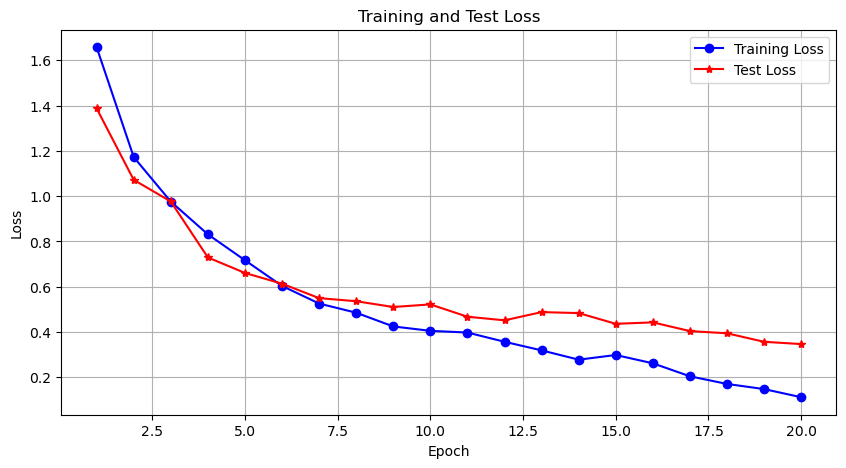

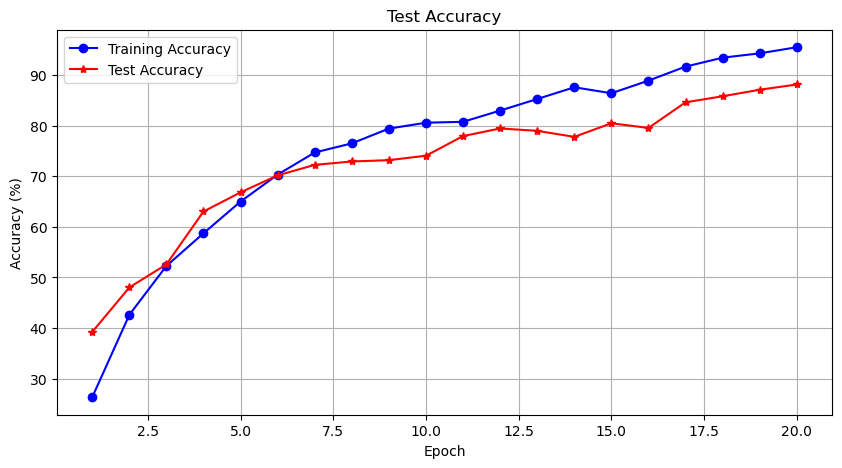

In [34]:
utils.plot_loss_epoch(train_loss_hist, val_loss_hist)
utils.plot_accuracy_epoch(val_acc_hist, train_acc_hist)

## Bonus task

In [58]:
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            3,
            64,
            kernel_size=7,
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [59]:
model_resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes = len(sequencesExtractor.get_classes()))

In [60]:
print(len(sequencesExtractor.get_classes()))

6


In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet = model_resnet.to(device)

In [62]:
model_parameters = filter(lambda p: p.requires_grad, model_resnet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

33206982


In [66]:
train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist = train_model_v4(num_epochs = num_epochs_resnet,
                                                                              chosen_model = model_resnet, 
                                                                              train_dataloader = train_dataloader, 
                                                                              val_dataloader = val_dataloader,
                                                                              optimizer = optimizer, 
                                                                              criterion = criterion,
                                                                              device = device,
                                                                              model_type = "resnet")

Epoch 1 Iter 31: loss 0.83210. train accuracy: 64.63414634146342: 100%|██████████████████████████████| 31/31 [00:03<00:00,  7.77it/s]


Val accuracy at epoch 0: 59.99%


Epoch 2 Iter 31: loss 0.66314. train accuracy: 75.60975609756098: 100%|██████████████████████████████| 31/31 [00:03<00:00,  7.77it/s]


Val accuracy at epoch 1: 63.51%


Epoch 3 Iter 31: loss 0.60445. train accuracy: 76.82926829268293: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.63it/s]


Val accuracy at epoch 2: 68.69%


Epoch 4 Iter 31: loss 0.58234. train accuracy: 76.82926829268293: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.74it/s]


Val accuracy at epoch 3: 70.55%


Epoch 5 Iter 31: loss 0.50388. train accuracy: 76.82926829268293: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.74it/s]


Val accuracy at epoch 4: 70.6%


Epoch 6 Iter 31: loss 0.44650. train accuracy: 82.92682926829268: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.67it/s]


Val accuracy at epoch 5: 73.6%


Epoch 7 Iter 31: loss 0.35005. train accuracy: 93.90243902439023: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.67it/s]


Val accuracy at epoch 6: 74.43%


Epoch 8 Iter 31: loss 0.30786. train accuracy: 95.1219512195122: 100%|███████████████████████████████| 31/31 [00:04<00:00,  7.59it/s]


Val accuracy at epoch 7: 71.58%


Epoch 9 Iter 31: loss 0.37030. train accuracy: 87.8048780487805: 100%|███████████████████████████████| 31/31 [00:04<00:00,  7.71it/s]


Val accuracy at epoch 8: 73.4%


Epoch 10 Iter 31: loss 0.27573. train accuracy: 91.46341463414635: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.68it/s]


Val accuracy at epoch 9: 76.92%


Epoch 11 Iter 31: loss 0.24422. train accuracy: 90.2439024390244: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.69it/s]


Val accuracy at epoch 10: 79.04%


Epoch 12 Iter 31: loss 0.23120. train accuracy: 95.1219512195122: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.63it/s]


Val accuracy at epoch 11: 74.38%


Epoch 13 Iter 31: loss 0.34042. train accuracy: 85.36585365853658: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.71it/s]


Val accuracy at epoch 12: 73.14%


Epoch 14 Iter 31: loss 0.33253. train accuracy: 87.8048780487805: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.71it/s]


Val accuracy at epoch 13: 80.49%


Epoch 15 Iter 31: loss 0.19427. train accuracy: 93.90243902439023: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.67it/s]


Val accuracy at epoch 14: 79.61%


Epoch 16 Iter 31: loss 0.20129. train accuracy: 92.6829268292683: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.71it/s]


Val accuracy at epoch 15: 78.05%


Epoch 17 Iter 31: loss 0.17442. train accuracy: 93.90243902439023: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.64it/s]


Val accuracy at epoch 16: 79.09%


Epoch 18 Iter 31: loss 0.17801. train accuracy: 95.1219512195122: 100%|██████████████████████████████| 31/31 [00:04<00:00,  7.66it/s]


Val accuracy at epoch 17: 80.02%


Epoch 19 Iter 31: loss 0.20227. train accuracy: 91.46341463414635: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.66it/s]


Val accuracy at epoch 18: 77.95%


Epoch 20 Iter 31: loss 0.16794. train accuracy: 96.34146341463415: 100%|█████████████████████████████| 31/31 [00:04<00:00,  7.64it/s]


Val accuracy at epoch 19: 79.5%


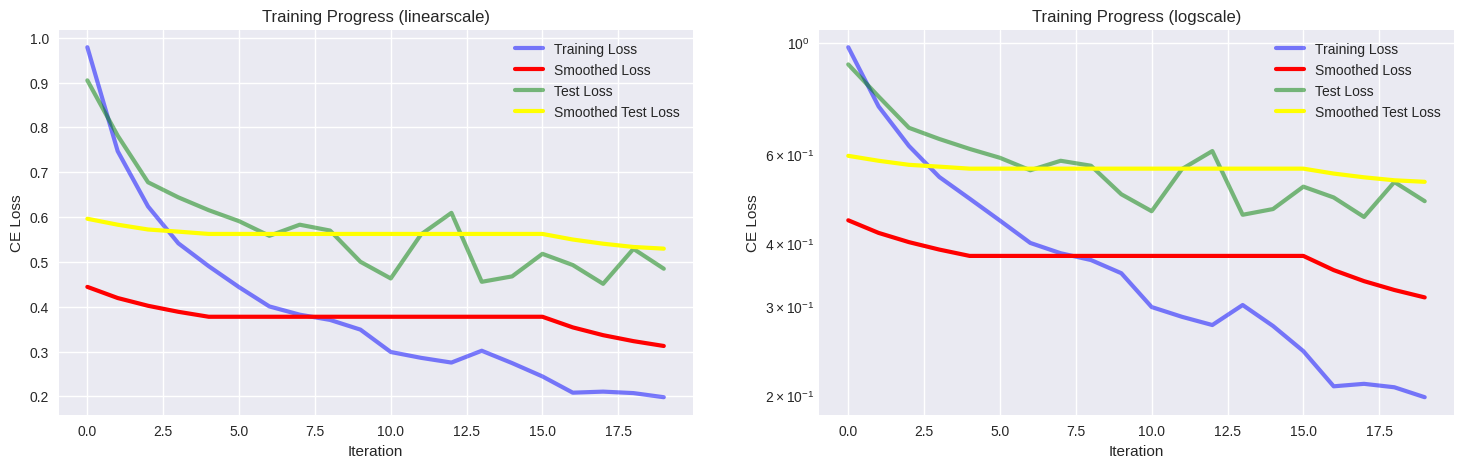

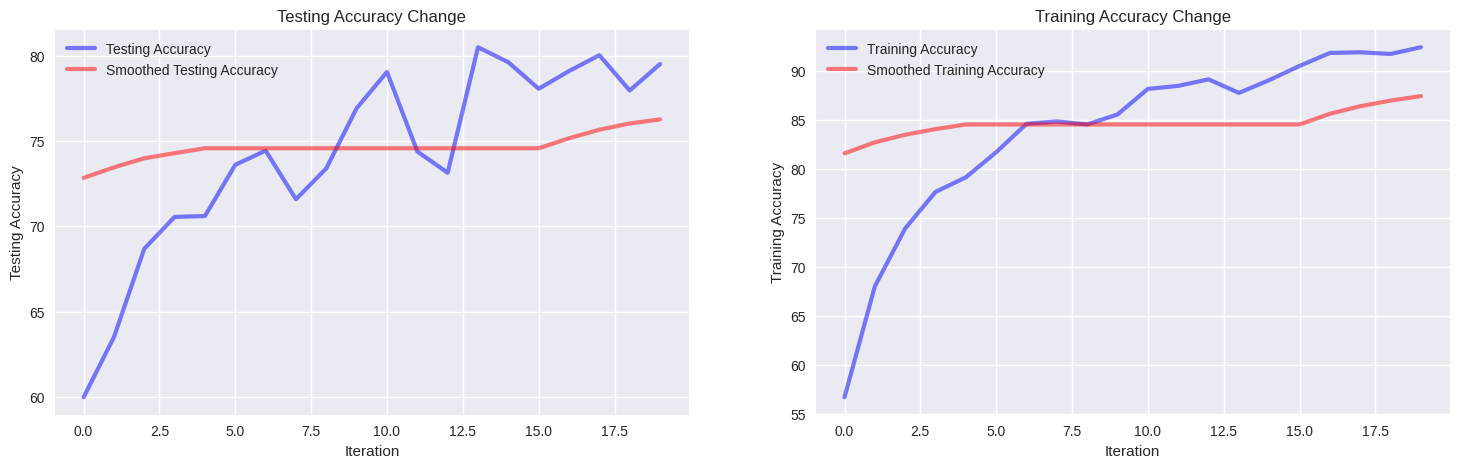

In [67]:
utils.plot_loss(train_loss_hist, val_loss_hist)
utils.plot_accuracy(train_acc_hist, val_acc_hist)